<a href="https://colab.research.google.com/github/haohe1113/translate-a-horse-to-a-zebra-cyclegan/blob/main/horse2zebra_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load images to .npz**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# load training data to .npz
import os
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images
def load_images(path, size=(256,256)):
	data_list = list()
	for filename in listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		data_list.append(pixels)
	return asarray(data_list)

path = '/content/drive/MyDrive/horse2zebra/'
# load train A
dataA1 = load_images(path + 'trainA/')
dataAB = load_images(path + 'testA/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load train B
dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path + 'testB/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as .npz
filename = 'h2z.npz'
savez_compressed(filename, dataA, dataB)

**train cycleGAN**

In [5]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-5aww_0py
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-5aww_0py
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=f1a5ad35019cdfd6228897bec1bd07e0390f480fd4bb4e3490f11bd3d7e5d815
  Stored in directory: /tmp/pip-ephem-wheel-cache-x2jzp_ve/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# function to create a discriminator
def make_discri(image_shape):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# function to create resnet block
def make_resnet(n_filters, input_layer):
	init = RandomNormal(stddev=0.02)
	# first convolution layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolution layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# merge output with input layer
	g = Concatenate()([g, input_layer])
	return g

# function to create a generator model
def make_gen(image_shape, n_resnet=9):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	# c64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = make_resnet(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

#function to create a composite model
def make_cmp(g_model_1, d_model, g_model_2, image_shape):
	g_model_1.trainable = True
	d_model.trainable = False
	g_model_2.trainable = False
	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle consistency loss (Fwd)
	output_f = g_model_2(gen1_out)
	# cycle consistency loss (Bwd)
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# upgrade model using adam sgd
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# load training data
def load_training_samples(filename):
	data = load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	# scale data
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	X = g_model.predict(dataset)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, gen_A, gen_B):
	filename1 = 'gen_A_%06d.h5' % (step+1)
	gen_A.save(filename1)
	filename2 = 'gen_B_%06d.h5' % (step+1)
	gen_B.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# generate samples and save as a plot and save the model
def performance(step, g_model, trainX, name, n_samples=5):
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all data
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

# function to create a image pool
def make_impl(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			selected.append(image)
		else:
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# training function
def train(discri_A, discri_B, gen_A, gen_B, cmp_A, cmp_B, dataset):
	n_epochs, n_batch, = 100, 1
	n_patch = discri_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs

	for i in range(n_steps):
   #real
		X_H_real, y_H_real = generate_real_samples(trainA, n_batch, n_patch)
		X_Z_real, y_Z_real = generate_real_samples(trainB, n_batch, n_patch)
  #fake
		X_H_fake, y_H_fake = generate_fake_samples(gen_B, X_Z_real, n_patch)
		X_Z_fake, y_Z_fake = generate_fake_samples(gen_A, X_H_real, n_patch)
  #update impl
		X_H_fake = make_impl(poolA, X_H_fake)
		X_Z_fake = make_impl(poolB, X_Z_fake)
		# adverasial loss
		gen_loss2, _, _, _, _  = cmp_B.train_on_batch([X_Z_real, X_H_real], [y_H_real, X_H_real, X_Z_real, X_H_real])
		# update discri_A
		discri_A_loss1 = discri_A.train_on_batch(X_H_real, y_H_real)
		discri_A_loss2 = discri_A.train_on_batch(X_H_fake, y_H_fake)
		# cycle consistency losses 
		gen_loss1, _, _, _, _ = cmp_A.train_on_batch([X_H_real, X_Z_real], [y_Z_real, X_Z_real, X_H_real, X_Z_real])
		# update discri_B
		discri_B_loss1 = discri_B.train_on_batch(X_Z_real, y_Z_real)
		discri_B_loss2 = discri_B.train_on_batch(X_Z_fake, y_Z_fake)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, discri_A_loss1,discri_A_loss2, discri_B_loss1,discri_B_loss2, gen_loss1,gen_loss2))
		# print model performance 
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot gen_A
			performance(i, gen_A, trainA, 'AtoB')
			# plot gen_B
			performance(i, gen_B, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			save_models(i, gen_A, gen_B)

dataset = load_training_samples('h2z.npz')
image_shape = dataset[0].shape[1:]
#create:
# gen_A
gen_A = make_gen(image_shape)
# gen_B
gen_B = make_gen(image_shape)
# discri_A
discri_A = make_discri(image_shape)
# discri_B
discri_B = make_discri(image_shape)
# cmp_A
cmp_A = make_cmp(gen_A, discri_B, gen_B, image_shape)
# cmp_B
cmp_B = make_cmp(gen_B, discri_A, gen_A, image_shape)
# train models
train(discri_A, discri_B, gen_A, gen_B, cmp_A, cmp_B, dataset)

**translate a single image (using an immature model for demonstration)**

In [7]:
!pwd

/content/drive/My Drive/horse2zebra


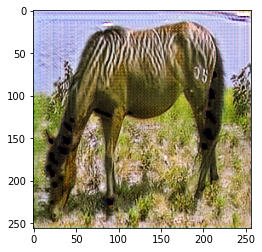

In [16]:
# example of using saved cyclegan models for image translation
from numpy import expand_dims
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot

# function to load one image for translation
def load_image(filename, size=(256,256)):
	pixels = load_img(filename, target_size=size)
	pixels = img_to_array(pixels)
	pixels = expand_dims(pixels, 0)
	# scale pixel
	pixels = (pixels - 127.5) / 127.5
	return pixels

# load the image
image_src = load_image('trainA/n02381460_195.jpg')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_011870.h5', cust)
# translate image
image_tar = model_AtoB.predict(image_src)
image_tar = (image_tar + 1) / 2.0
# plot outcome image
pyplot.imshow(image_tar[0])
pyplot.show()

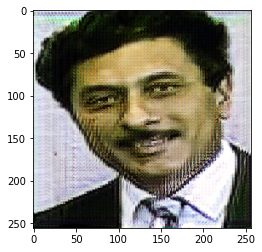

In [15]:
# load the image
image_src = load_image('trainA/barua.jpg')
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_011870.h5', cust)
# translate image
image_tar = model_AtoB.predict(image_src)
image_tar = (image_tar + 1) / 2.0
# plot outcome image
pyplot.imshow(image_tar[0])
pyplot.show()